<a href="https://colab.research.google.com/github/renyuanL/_JosephLin_2023/blob/main/ry_mlp_fromAndrej_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

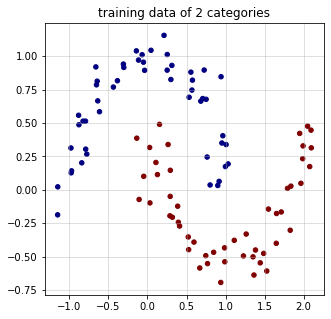

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(5), ReLUNeuron(5), ReLUNeuron(5), ReLUNeuron(5), ReLUNeuron(5)], Layer of [LinearNeuron(5)]]
number of parameters 51
Before Training...
 total_loss= Value(data=1.1350556189465284, grad=0)
acc= 0.5

step 0: total_loss= Value(data=1.1350556189465284, grad=1), acc= 0.5
step 10: total_loss= Value(data=0.3515014789892078, grad=1), acc= 0.85
step 20: total_loss= Value(data=0.268368828830802, grad=1), acc= 0.87
step 30: total_loss= Value(data=0.2514928735702435, grad=1), acc= 0.88
step 40: total_loss= Value(data=0.2508889565402807, grad=1), acc= 0.88
step 50: total_loss= Value(data=0.24449166613454937, grad=1), acc= 0.88
step 60: total_loss= Value(data=0.24244667390320995, grad=1), acc= 0.89
step 70: total_loss= Value(data=0.24470758469925902, grad=1), acc= 0.89
step 80: total_loss= Value(data=0.2381851045346389, grad=1), acc= 0.89
step 90: total_loss= Value(data=0.23522445090475

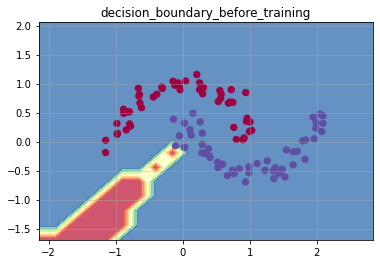

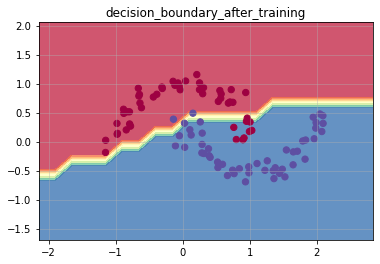

In [1]:
# ry_mlp_fromAndrej.py
#
# Author: Renyuan Lyu, 
# Date: 2023-04-01
#
# Adapted from Andrej Karpathy 
# https://github.com/karpathy/micrograd
# https://youtu.be/VMj-3S1tku0
#

import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs

class Value:
    """ stores a single scalar value and its gradient"""

    def __init__(self, data, _children= (), _op= ''):
        self.data= data # the value of this node in the graph
        self.grad= 0    # the gradient of this node wrt to the loss
        
        # internal variables used for autograd graph construction
        self._backward= lambda: None   # an empty function
        self._prev=     set(_children) # a set of all the nodes that produced this node 
        
        self._op= _op 
        # the op that produced this node, 
        # for graphviz / debugging / etc

    def __add__(self, other):
        '''
        self + other
        '''
        
        other= (other if isinstance(other, Value) else 
                Value(other))
        
        out= Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad  += out.grad
            other.grad += out.grad
        
        out._backward= _backward

        return out

    def __mul__(self, other):
        '''
        self * other
        '''
        other= other if isinstance(other, Value) else Value(other)
        out=   Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        '''
        self ** other
        '''

        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        
        out= Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad

        out._backward = _backward

        return out

    def relu(self):
        '''
        ReLU activation function
        '''
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        '''
        tanh activation function
        this is a non-linear activation function
        it is automatically generated by co-pilot
        '''
        out = Value(np.tanh(self.data), (self,), 'tanh')

        def _backward():
            self.grad += (1 - np.tanh(self.data)**2) * out.grad
        out._backward = _backward

        return out
    
    def sigmoid(self):
        '''
        sigmoid activation function
        this is a non-linear activation function
        it is automatically generated by co-pilot
        '''
        out = Value(1/(1 + np.exp(-self.data)), (self,), 'sigmoid')

        def _backward():
            #self.grad += (1 - 1/(1 + np.exp(-self.data))) * out.grad
            self.grad += out.data * (1-out.data) * out.grad

        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad= 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin= True):
        self.w= [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b= Value(0)
        self.nonlin= nonlin

    def __call__(self, x):
        '''
        x: input vector
        '''
        # z= x @ self.w + self.b
        z= sum((xi*wi for xi, wi in zip(x, self.w)), 
                  self.b)
        y= (z.relu() if self.nonlin else 
            z)
        return y

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz= [nin] + nouts
        self.layers= [
            Layer(sz[i], sz[i+1], nonlin= (i!=len(nouts)-1)) 
            for i in range(len(nouts))
            ]

    def __call__(self, x):
        for layer in self.layers:
            x= layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

# loss function
def loss(X, y, model, batch_size=None):
    '''
    X : (n,d) array of n d-dimensional inputs
    y : (n,) array of n labels
    model : a function that takes an (d,) array and returns a scalar
    batch_size : if not None, use SGD with this batch size
    '''
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]

    return total_loss, sum(accuracy) / len(accuracy)

def visualize_decision_boundary(X, y, model, 
                                title= 'decision_boundary', 
                                show=True):
    '''
    Visualize the decision boundary of a 2D model.
    '''
    
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.title(title)

    if show==True:
        plt.show()

def main():

    # make up a dataset

    X, y= make_moons(n_samples=100, noise=0.1)
    
    y= y*2 - 1 # make y be -1 or 1

    # visualize dataset in 2D
    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0], X[:,1], 
                c=y, s=20, cmap='jet')
    plt.title('training data of 2 categories')
    plt.show()

    # initialize a model 
    model= MLP(2, [5, 5, 1]) # 2-layer neural network
    
    # visualize the model
    print(model)
    print("number of parameters", 
          len(model.parameters()))

    # estimating the loss and acc, 
    # and then visualize the decision boundary before training
    
    total_loss, acc= loss(X, y, model)
    print(f'Before Training...\n {total_loss= }\n{acc= }\n')
    visualize_decision_boundary(
        X, y, model, 
        show=False, 
        title= 'decision_boundary_before_training')

    #input('Press any key to start training ...')

    # optimization, training
    epochs= 100
    for k in range(epochs):
        
        # forward
        total_loss, acc = loss(X,y,model)
        
        # backward
        model.zero_grad()
        total_loss.backward()
        
        # update (sgd)
        learning_rate = 1.0 - 0.9*k/epochs
        for p in model.parameters():
            p.data -= learning_rate * p.grad
        
        if k % 10 == 0:
            print(f"step {k}: {total_loss= }, {acc= }")
            #visualize_decision_boundary(X, y, model, show=False)

    visualize_decision_boundary(
        X, y, model, 
        title= 'decision_boundary_after_training', 
        show=True)

if __name__ == '__main__':
    main()